# Codebook For UNet Analysis

### Imports

In [61]:
import os
import torch
from torch import nn
import numpy as np
from utils import *
from unet import *
from skimage.filters import threshold_otsu

## Checking Validity of Data
Checking on average how often do nonzero pixels in our image overlap.
AKA asking if there is bleedthrough for our identity images and if so, how much?

In [53]:
directory_path = 'data/slices/'
data_filenames = list(os.listdir(directory_path))

In [25]:
# no otsu threshold
percent_overlap = []
num_elements = 0
for filename in data_filenames:
    path = directory_path + filename
    img = torch.load(path)
    if not num_elements:
        num_elements = img[0].numel()
    x = torch.count_nonzero(torch.count_nonzero(img, dim=0) >= 2)
    percent_overlap.append(x/num_elements)

In [26]:
print(torch.Tensor(percent_overlap).mean().item() * 100, ' percent')

100.0  percent


In [27]:
# otsu threshold on each channel
percent_overlap = []
num_elements = 0
for filename in data_filenames:
    path = directory_path + filename
    img = torch.load(path).numpy()
    img = np.array([img[i] > threshold_otsu(img[i]) for i in range(img.shape[0])])
    if not num_elements:
        num_elements = img[0].size
    x = np.count_nonzero(np.count_nonzero(img, axis=0) >= 2)
    percent_overlap.append(x/num_elements)

In [28]:
print(np.mean(percent_overlap) * 100, ' percent')

1.0322639677259657  percent


In [49]:
img = torch.load(path).numpy()
img = np.array([img[i] > threshold_otsu(img[i]) for i in range(img.shape[0])])
bleed_mask = np.count_nonzero(img, axis=0) >= 2
flattened_img = img.max(axis=0)
bleed_img = flattened_img * bleed_mask

In [58]:
print(path)

data/slices/F051_trim_manual_9.pt


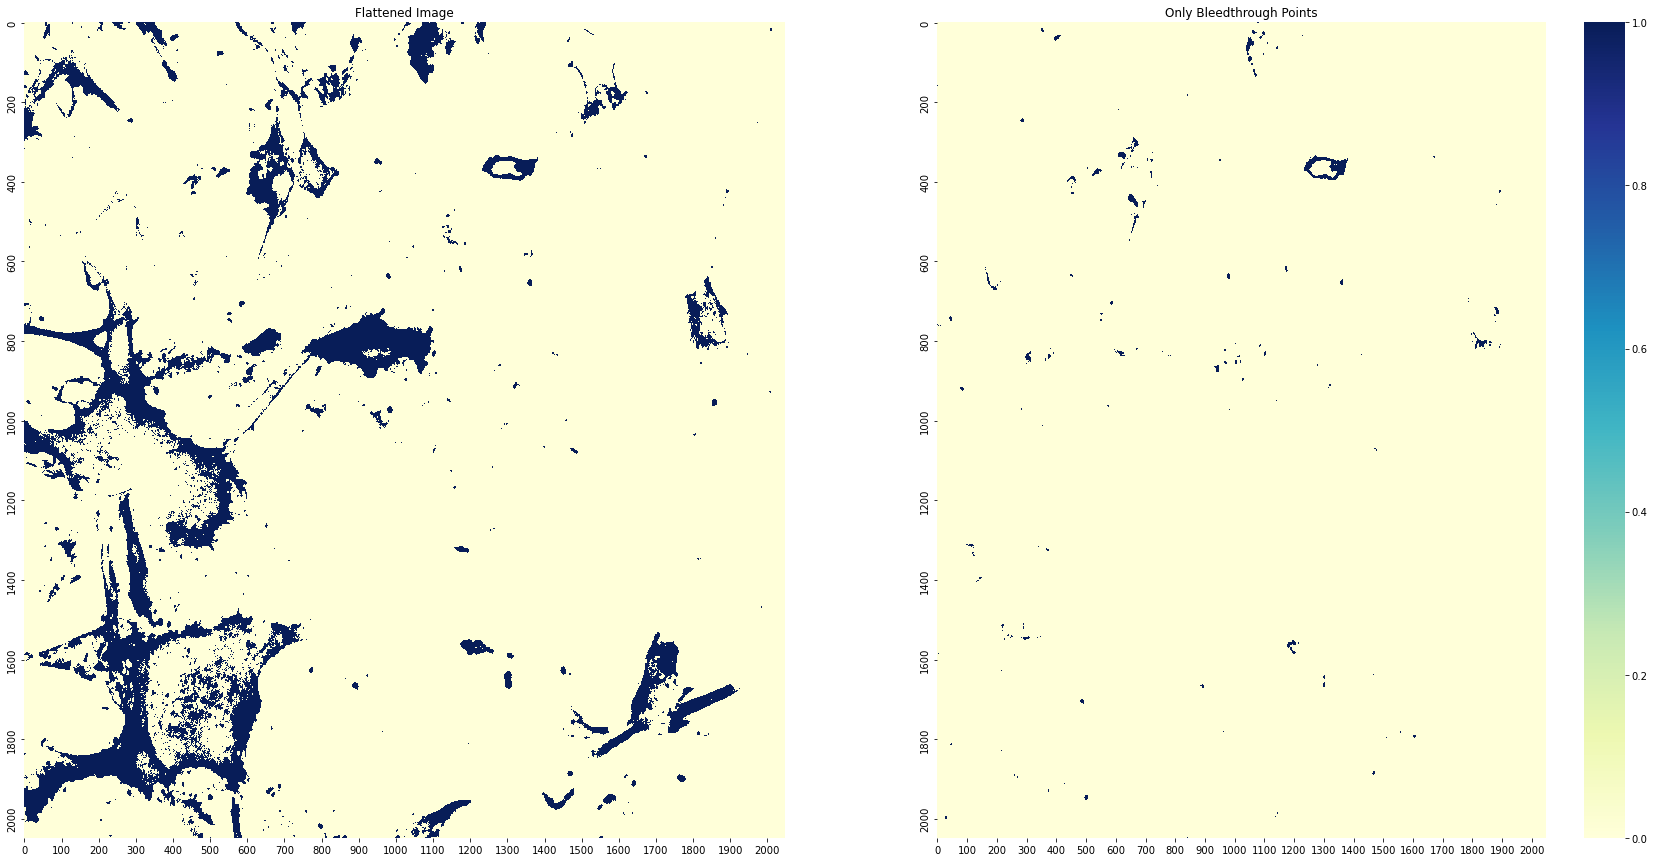

In [51]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].title.set_text('Flattened Image')
axs[1].title.set_text('Only Bleedthrough Points')
sns.heatmap(flattened_img, xticklabels=100, yticklabels=200, ax=axs[0], cmap="YlGnBu", cbar=False)
sns.heatmap(bleed_img, xticklabels=100, yticklabels=200, ax=axs[1], cmap="YlGnBu")

plt.show()

In [59]:
print(directory_path+data_filenames[4])

data/slices/F030_trim_manual_4.pt


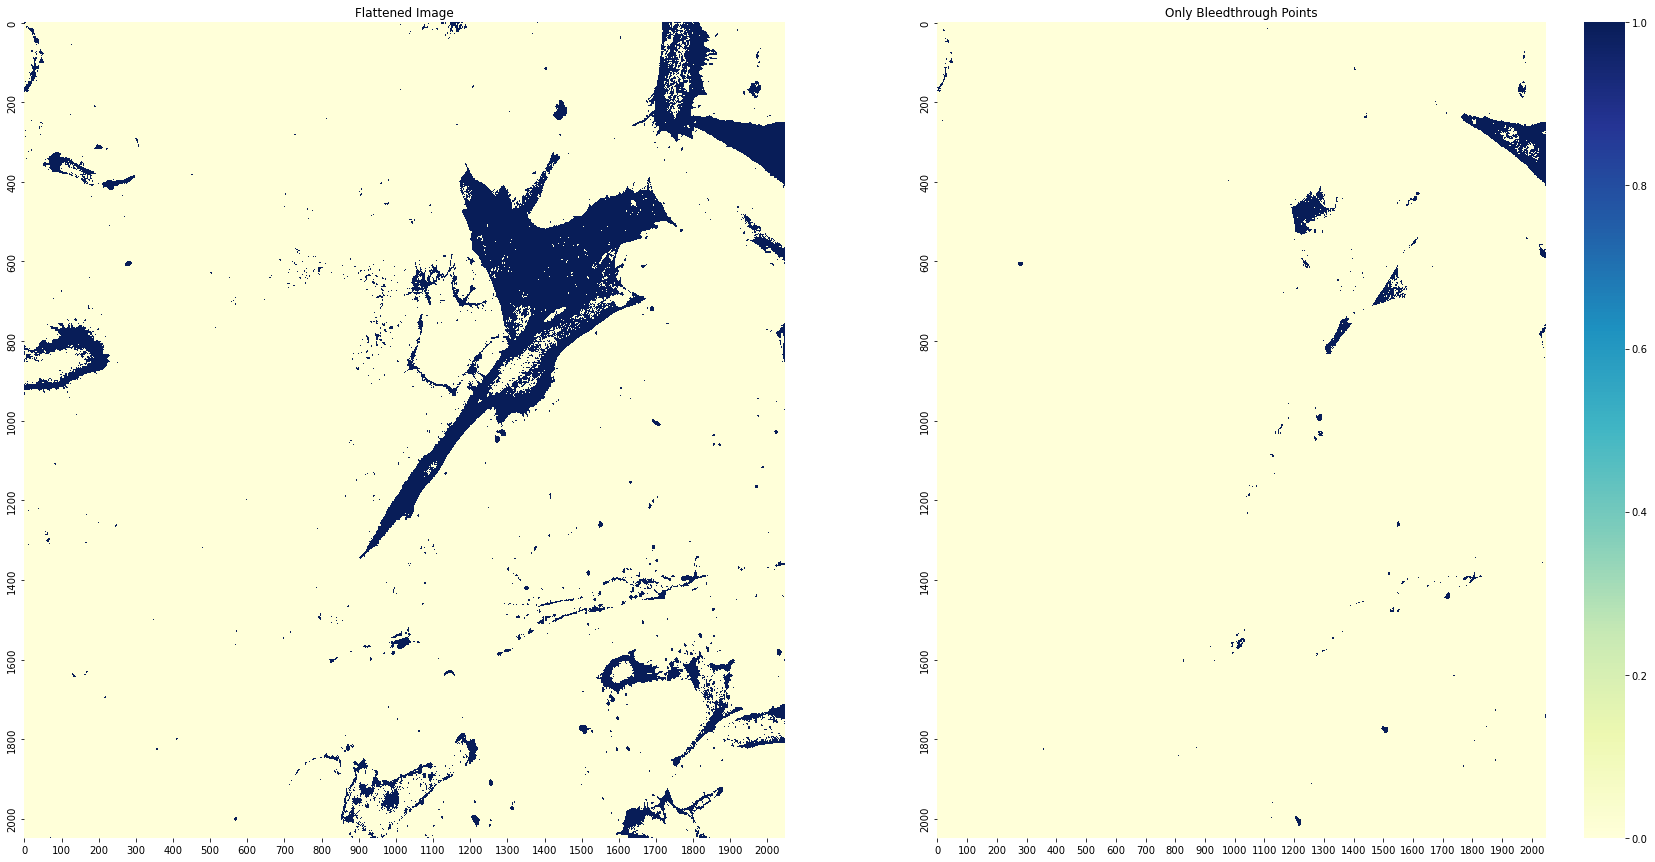

In [56]:
img = torch.load(directory_path+data_filenames[4]).numpy()
img = np.array([img[i] > threshold_otsu(img[i]) for i in range(img.shape[0])])
bleed_mask = np.count_nonzero(img, axis=0) >= 2
flattened_img = img.max(axis=0)
bleed_img = flattened_img * bleed_mask
fig, axs = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].title.set_text('Flattened Image')
axs[1].title.set_text('Only Bleedthrough Points')
sns.heatmap(flattened_img, xticklabels=100, yticklabels=200, ax=axs[0], cmap="YlGnBu", cbar=False)
sns.heatmap(bleed_img, xticklabels=100, yticklabels=200, ax=axs[1], cmap="YlGnBu")

plt.show()

# Testing Model W/ Different Loss Functions

<img src="unet.png">

In [76]:
unet = UNet(num_class = 3, retain_dim=True, out_sz=(2048,2048), dropout=0.15)
print(unet)

UNet(
  (encoder): Encoder(
    (encoder_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (dropout): Dropout(p=0.15, inplace=False)
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
        (dropout): Dropout(p=0.15, inplace=False)
    

In [64]:
directory_path = 'models/'

## Mean Squared Error

In [65]:
checkpoint_name = "200_mse_3_blob.tar"
checkpoint = torch.load(directory_path + checkpoint_name)
train_loss = checkpoint['train_losses']
checkpoint_name = "200_mse_3_blob_dropout.tar"
checkpoint_dropout = torch.load(directory_path + checkpoint_name)
train_loss_dropout = checkpoint['train_losses']

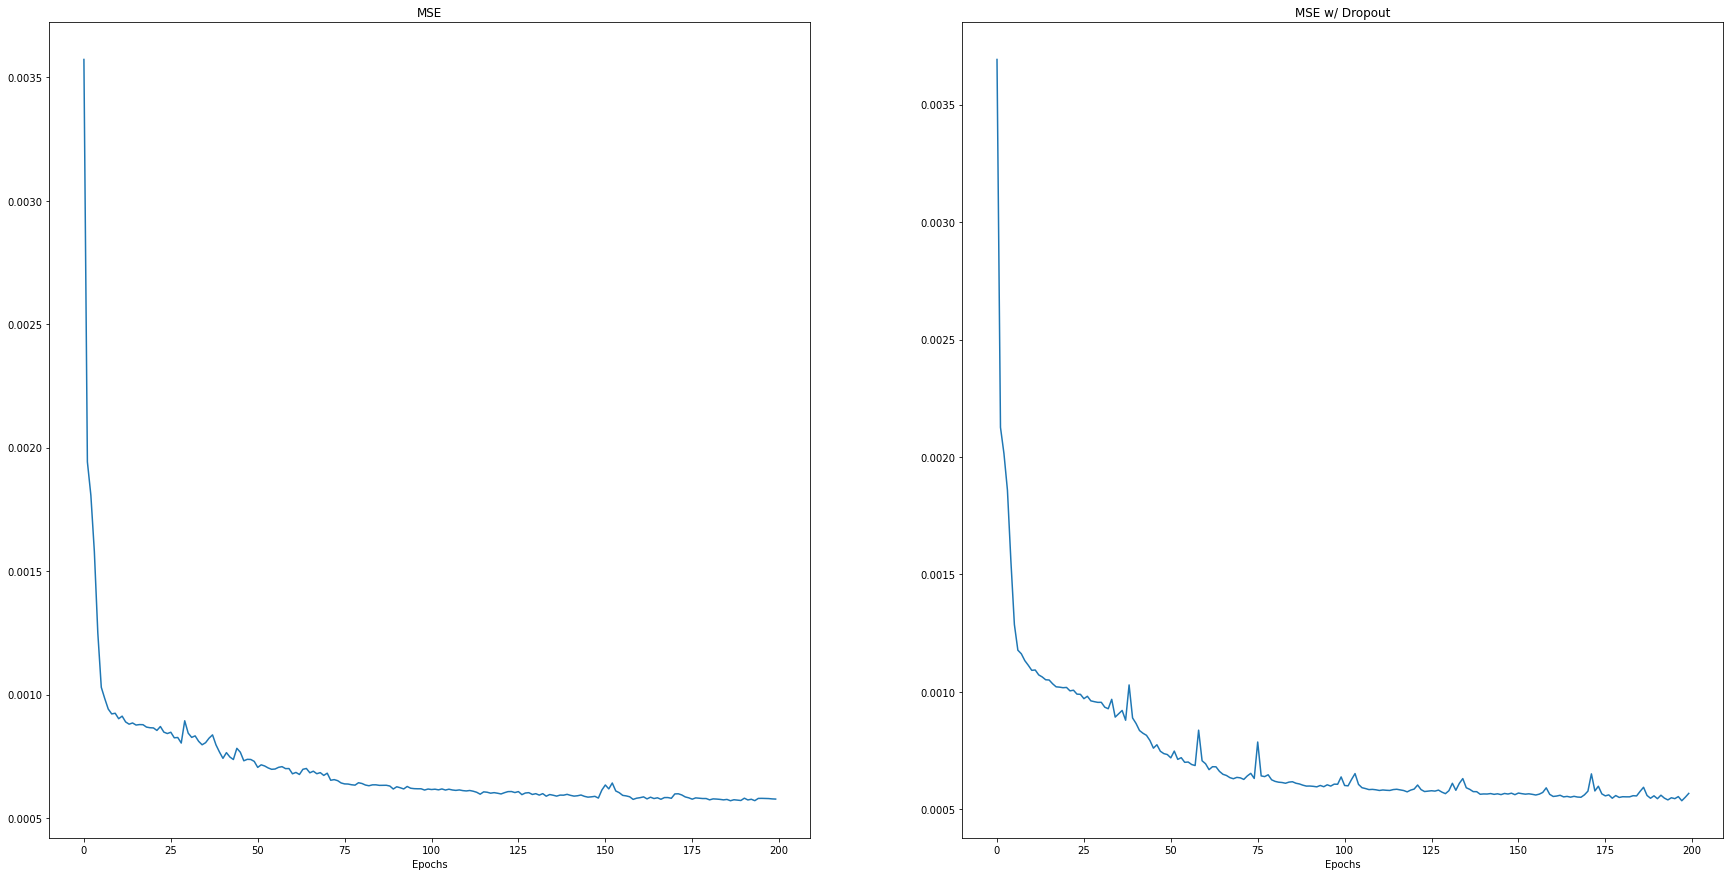

In [15]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].set_xlabel('Epochs')
axs[1].set_xlabel('Epochs')
axs[0].plot(train_loss)
axs[0].title.set_text('MSE')
axs[1].plot(train_loss_dropout)
axs[1].title.set_text('MSE w/ Dropout')


In [93]:
img_01 = torch.load('data/F051_trim_manual_9.pt').view(4,2048,2048).cpu()
img_01 = img_01.detach().numpy()

img_1 = torch.load('200_mse_3_blob_dropout._0.pt').view(3,2048,2048).cpu()
img_1 = img_1.detach().numpy()

img_02 = torch.load('data/F030_trim_manual_4.pt').view(4,2048,2048).cpu()
img_02 = img_02.detach().numpy()

img_2 = torch.load('200_mse_3_blob_dropout._1.pt').view(3,2048,2048).cpu()
img_2 = img_2.detach().numpy()

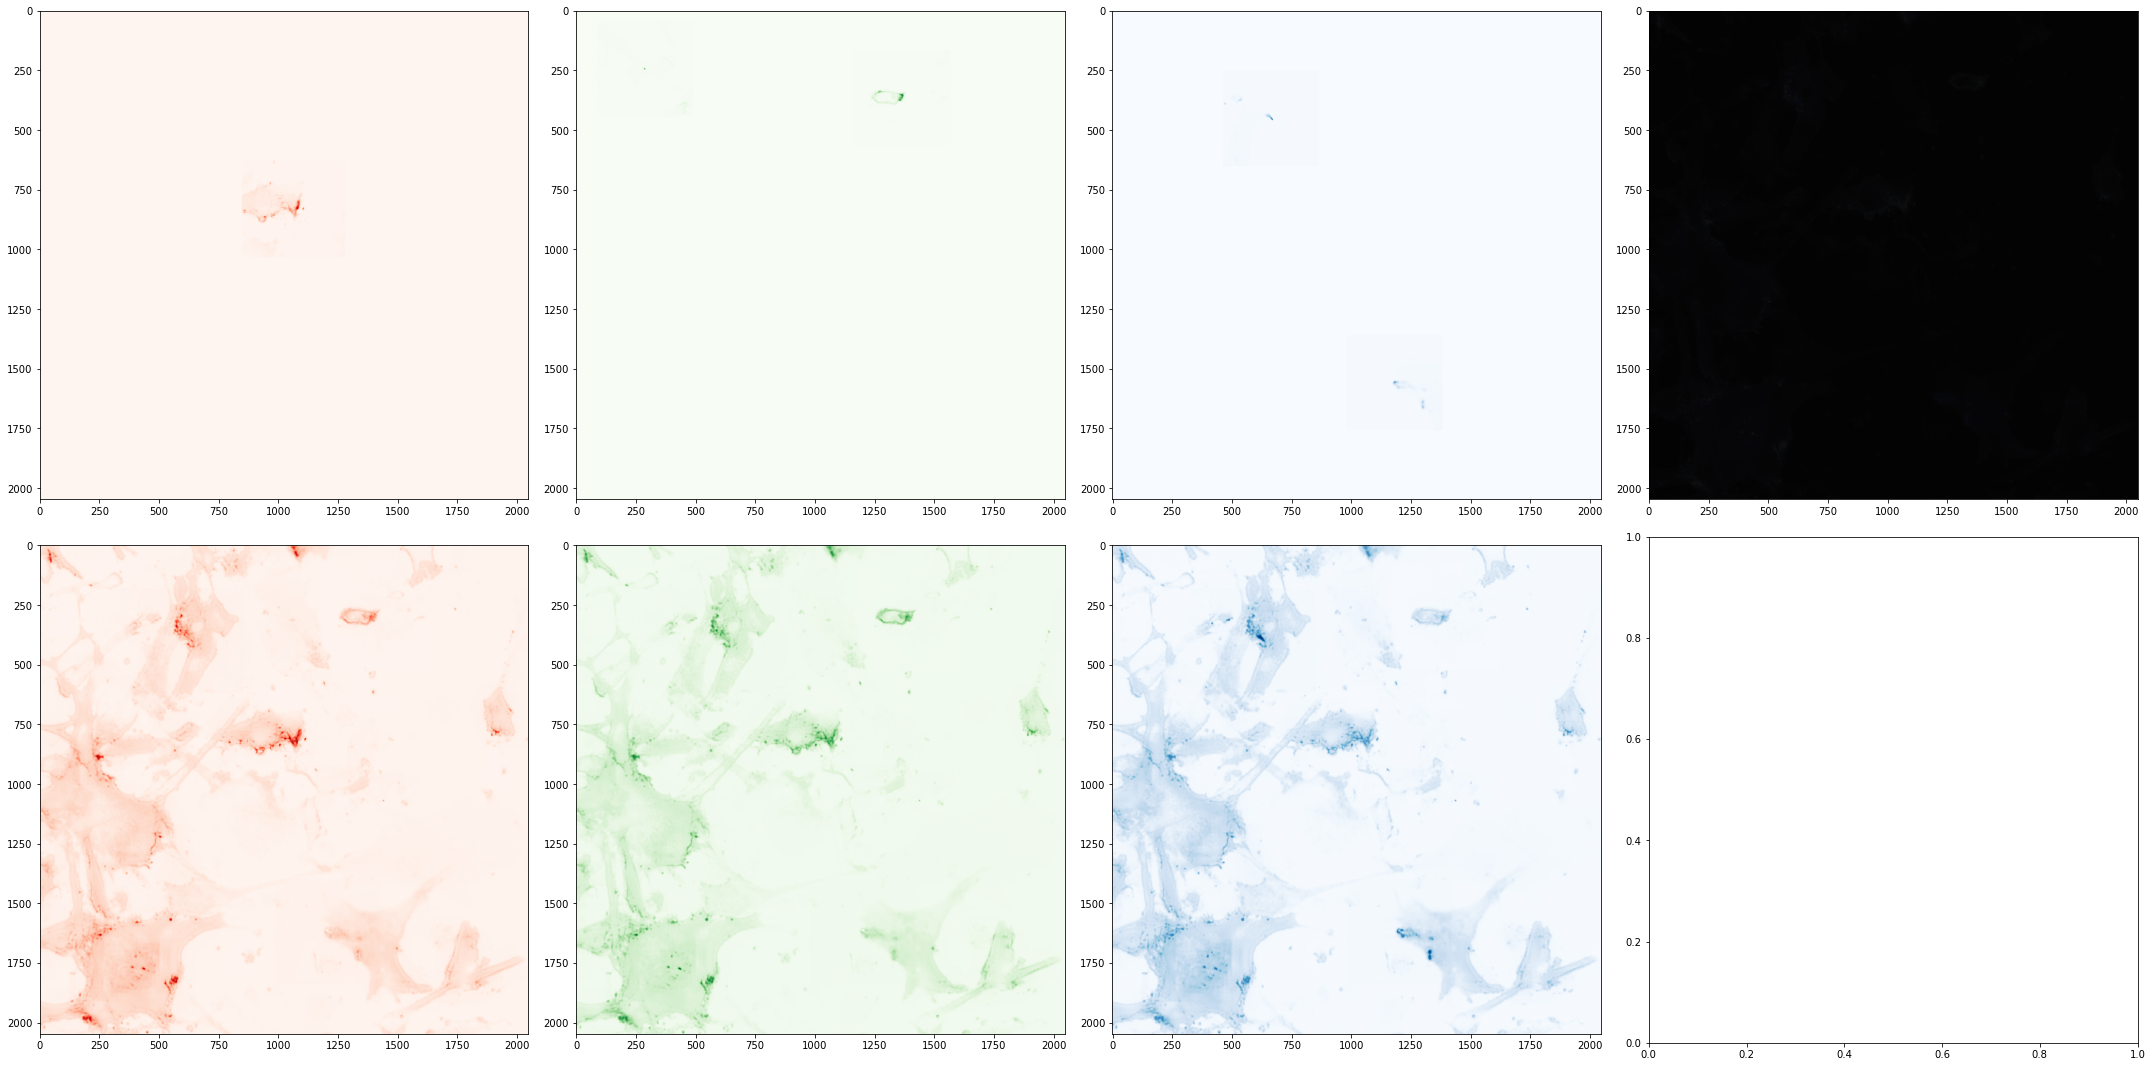

In [158]:
fig, axs = plt.subplots(2,4)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0][0].imshow(img_01[1]*10, cmap='Reds')
axs[0][1].imshow(img_01[2]*10, cmap='Greens')
axs[0][2].imshow(img_01[3]*10, cmap='Blues')
axs[0][3].imshow(img_01[0])


axs[1][0].imshow(img_1[0], cmap='Reds')
axs[1][1].imshow(img_1[1], cmap='Greens')
axs[1][2].imshow(img_1[2], cmap='Blues')
axs[0][3].imshow(np.stack(img_1,-1))

plt.tight_layout()
plt.show()

In [175]:
img_2_target = torch.load('data/slices/F030_trim_manual_4.pt').view(3,2048,2048).cpu()
img_2_target = img_2_target.detach().numpy()
img_1_target = torch.load('data/slices/F051_trim_manual_9.pt').view(3,2048,2048).cpu()
img_1_target = img_1_target.detach().numpy()

In [148]:
img_2_target.shape

(3, 2048, 2048)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


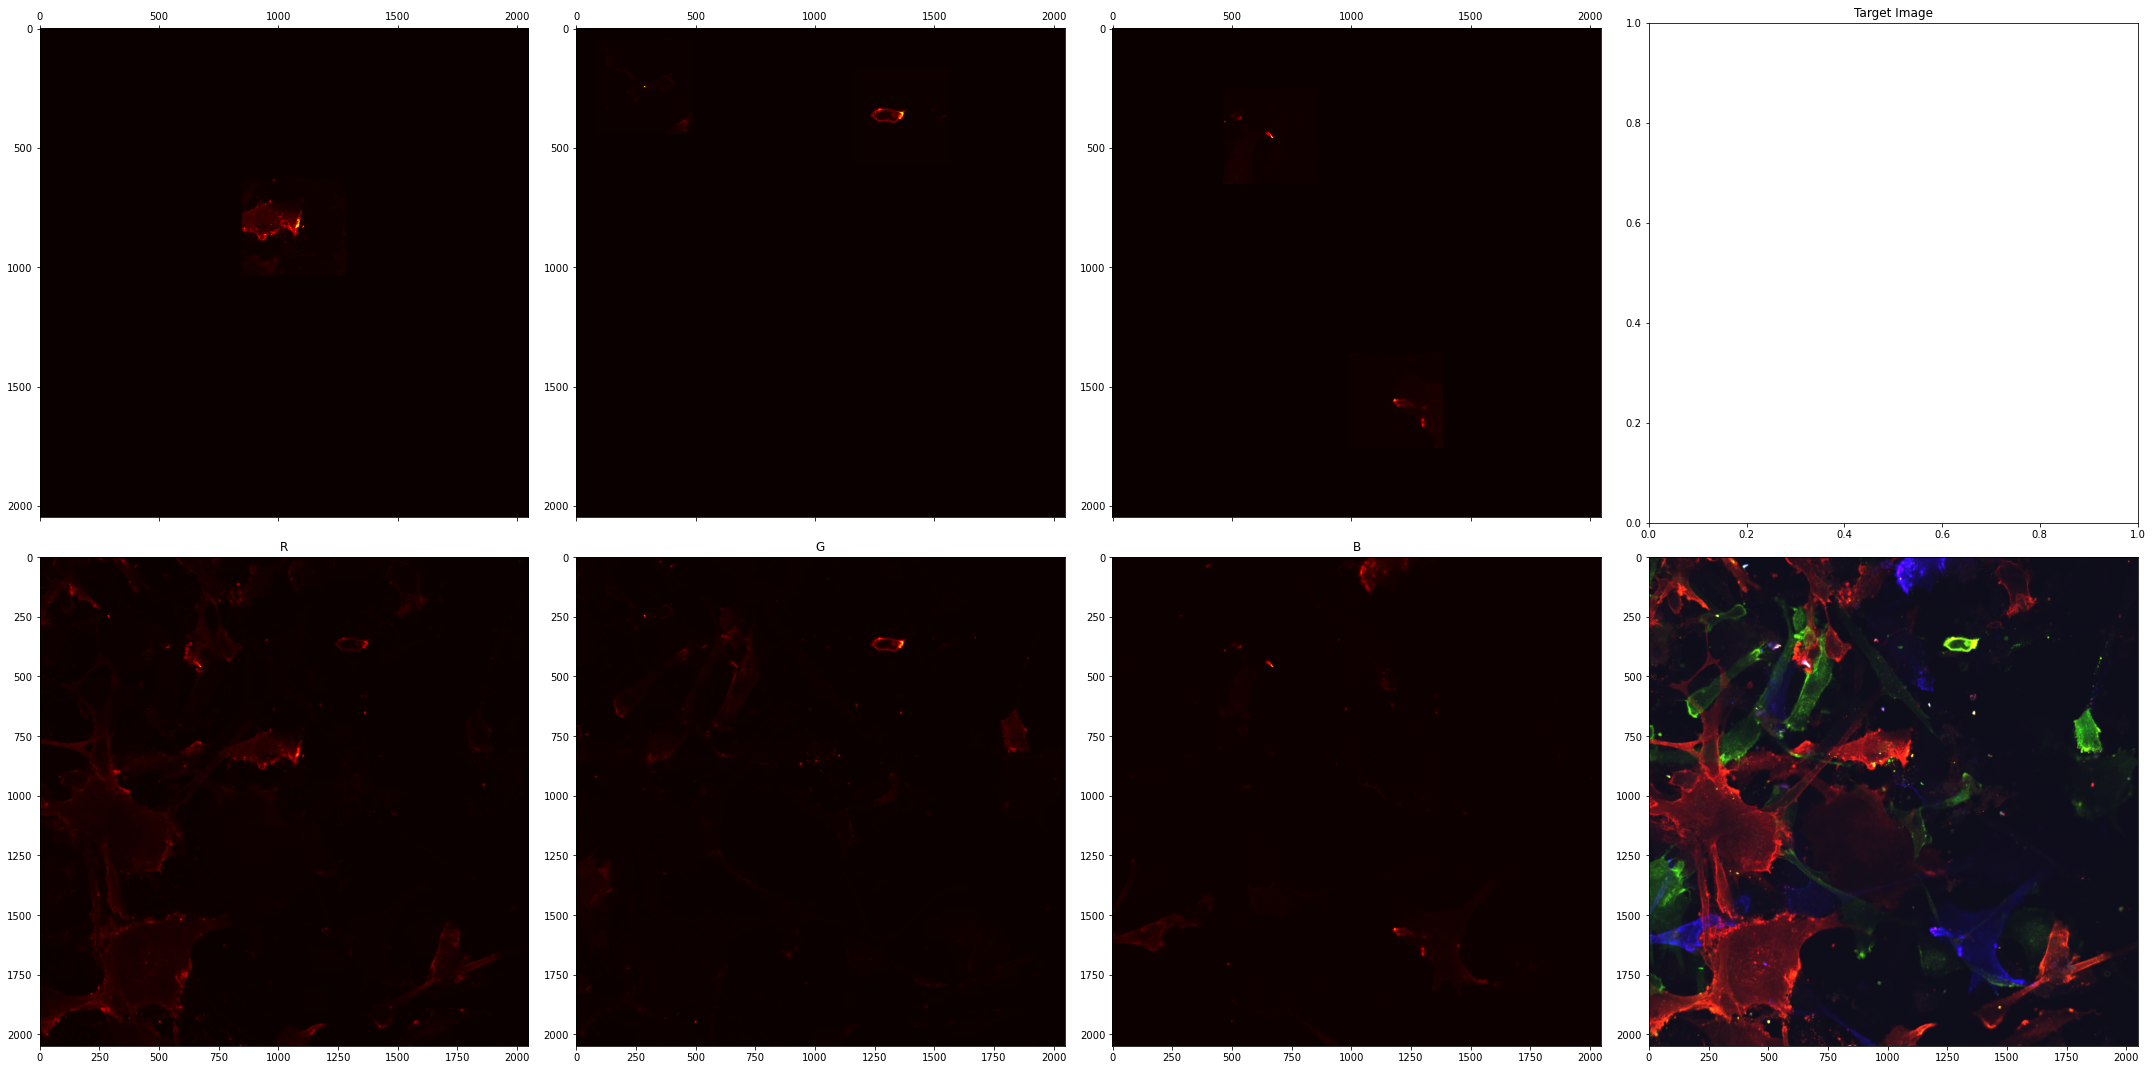

In [176]:
fig, axs = plt.subplots(2,4)
fig.set_figheight(15)
fig.set_figwidth(30)

superposed_blobs = np.stack([img_02[1], img_02[2], img_02[3]],-1)
axs[0][0].matshow(img_01[1] * 10, cmap='hot')


axs[0][1].matshow(img_01[2] * 10, cmap='hot')
axs[0][2].matshow(img_01[3] * 10, cmap='hot')

axs[0][3].title.set_text('Target Image')
axs[1][3].imshow(np.stack([img_1_target[0], img_1_target[1], img_1_target[2]],-1)*10)

axs[1][0].imshow(img_1_target[0]*100, cmap='hot')
axs[1][0].title.set_text('R')

axs[1][1].imshow(img_1_target[1]*100, cmap='hot')
axs[1][1].title.set_text('G')

axs[1][2].imshow(img_1_target[2]*100, cmap='hot')
axs[1][2].title.set_text('B')


plt.tight_layout()
plt.show()


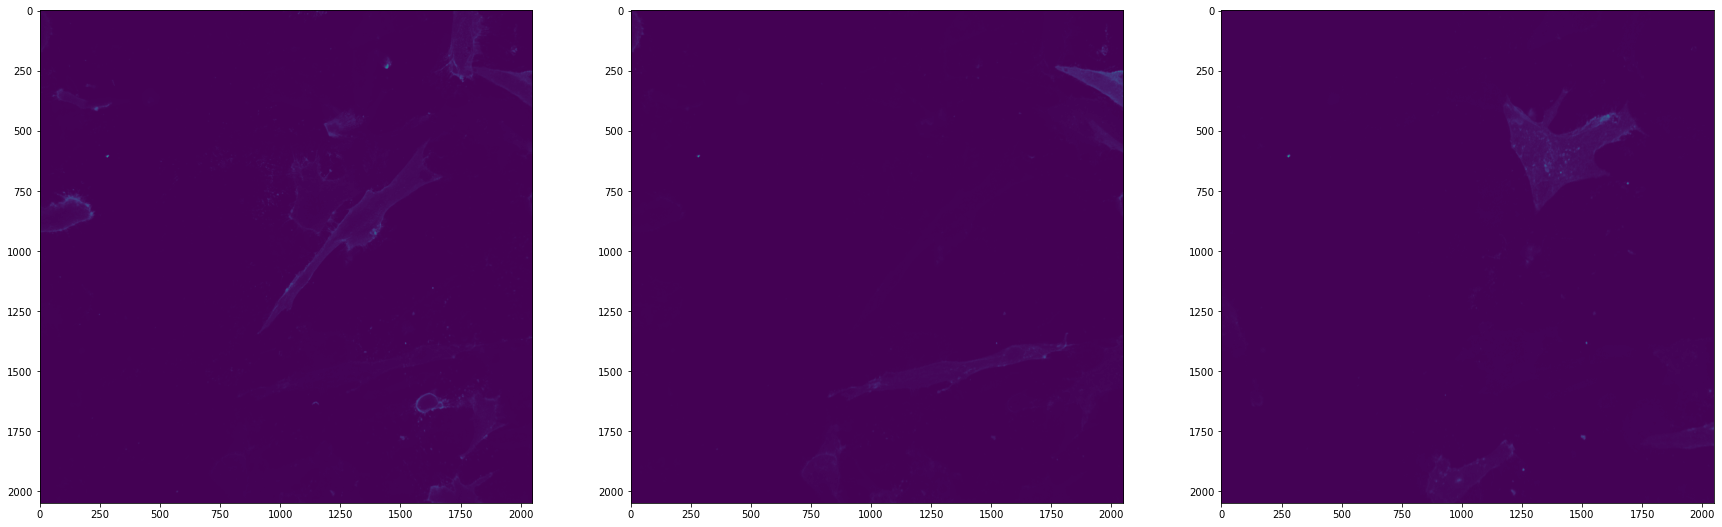

In [155]:
fig, axs = plt.subplots(1,3)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].imshow(img_2_target[0]*10)
axs[1].imshow(img_2_target[1]*10)
axs[2].imshow(img_2_target[2]*10)
plt.show()

In [126]:
superposed_image.max()

0.08831919

In [118]:
np.stack(img_2,-1).shape

(2048, 2048, 3)

## Focal Loss

In [17]:
checkpoint_name = "180_focal_loss_3_blobs.tar"
checkpoint = torch.load(directory_path + checkpoint_name)
train_loss = checkpoint['train_losses']
checkpoint_name = "200_focal_3_blob_dropout.tar"
checkpoint = torch.load(directory_path + checkpoint_name)
train_loss_dropout = checkpoint['train_losses']

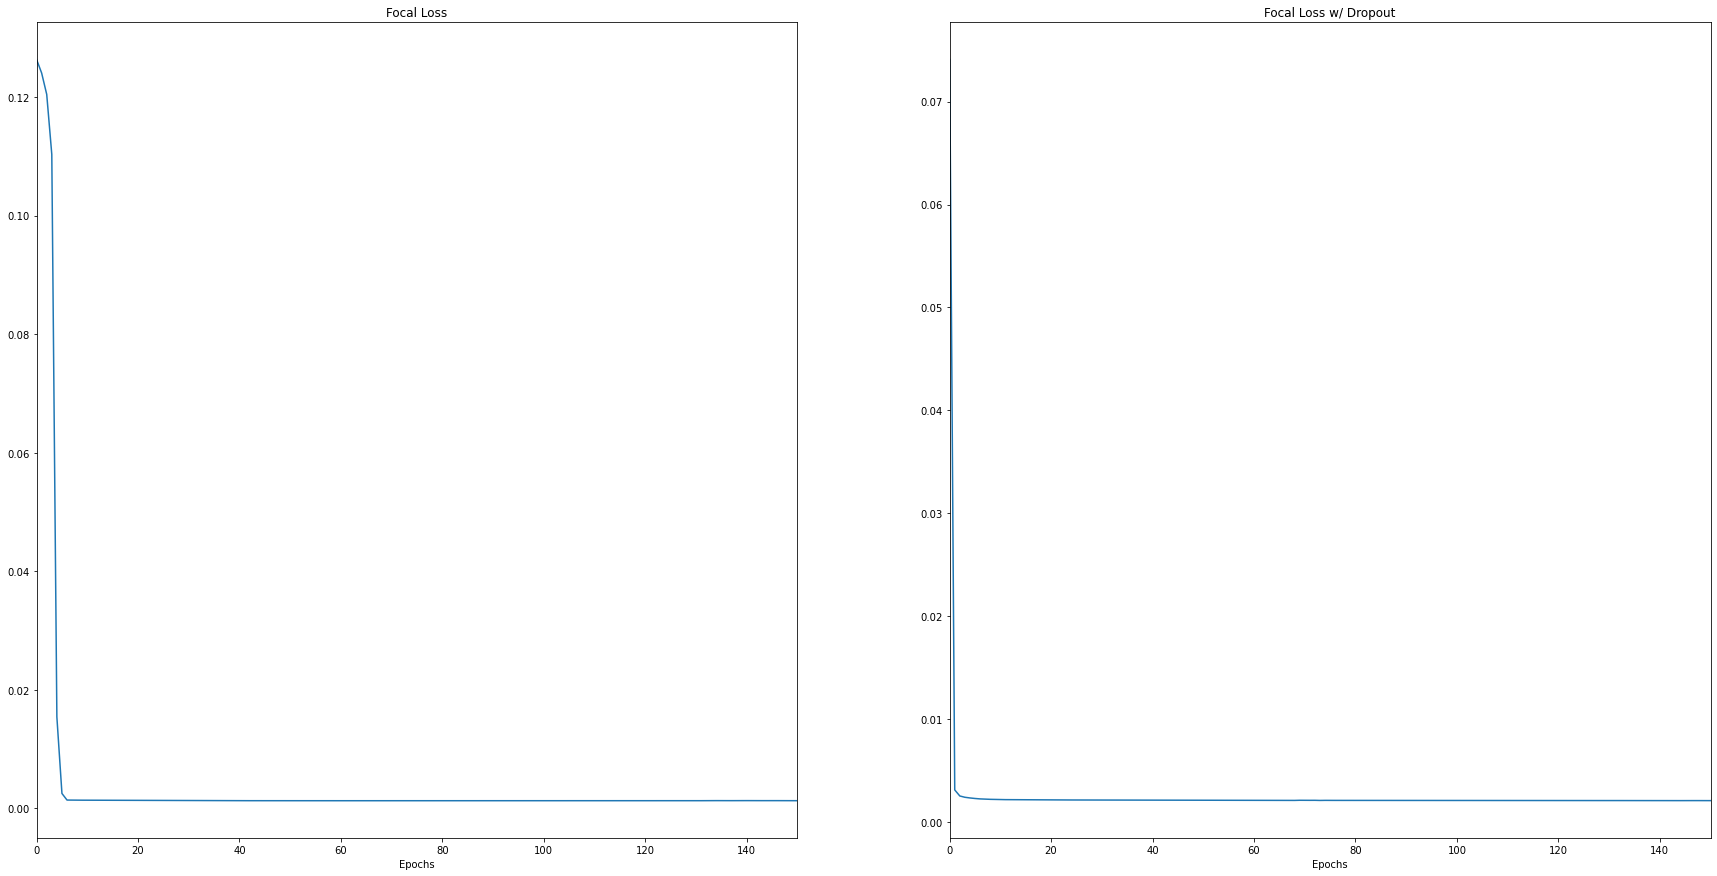

In [19]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].set_xlabel('Epochs')
axs[0].set_xlim([0,150])
axs[1].set_xlabel('Epochs')
axs[1].set_xlim([0,150])
axs[0].plot(train_loss)
axs[0].title.set_text('Focal Loss')
axs[1].plot(train_loss_dropout)
axs[1].title.set_text('Focal Loss w/ Dropout')

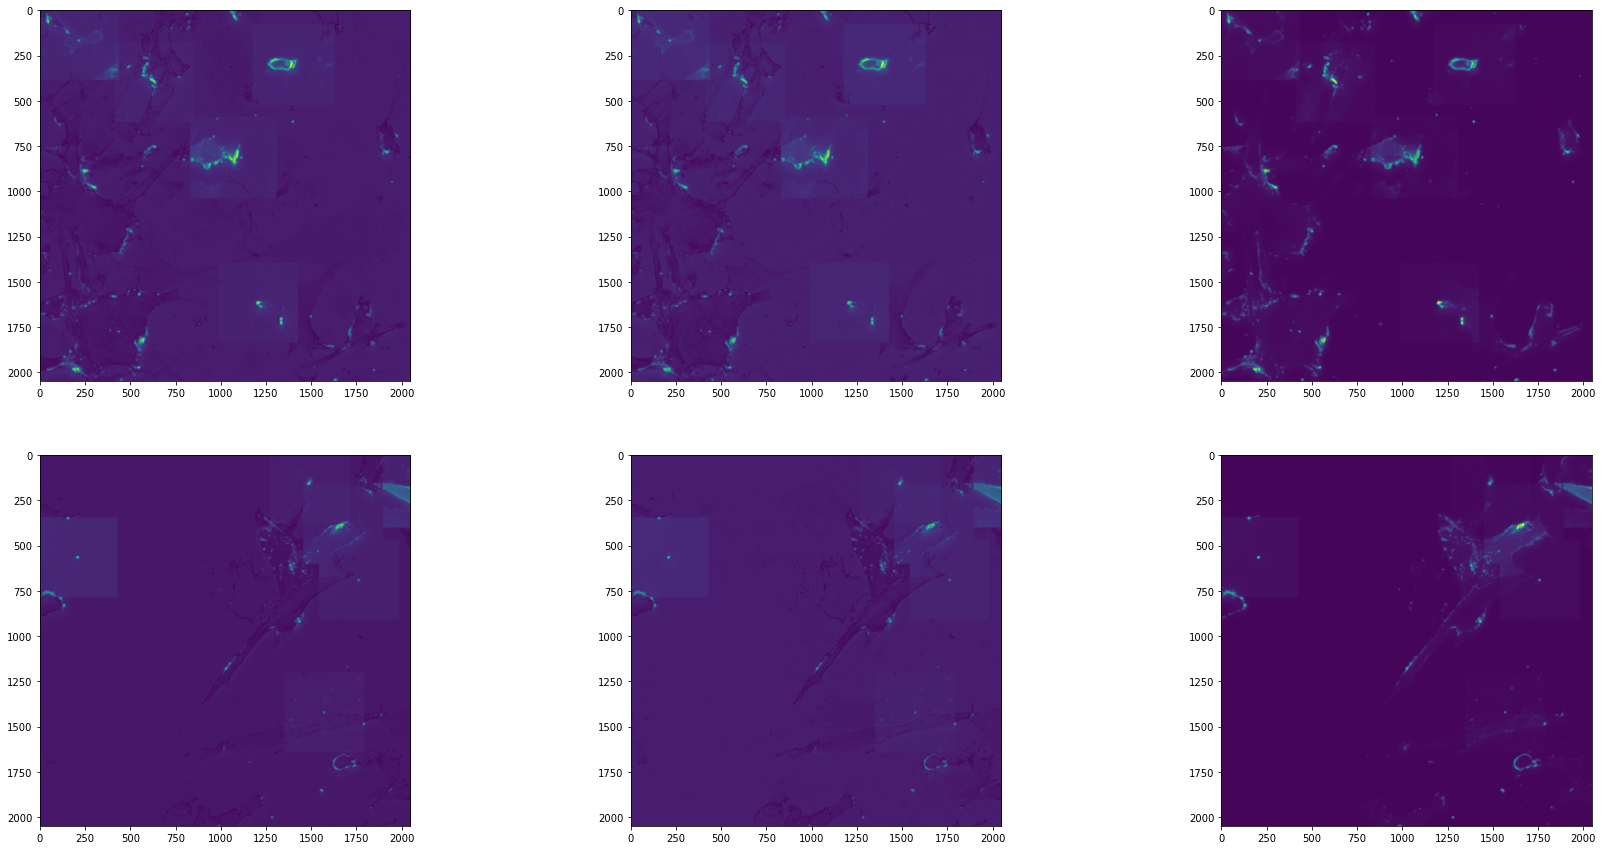

In [89]:
img_01 = torch.load('200_focal_3_blob_dropout._0.pt').view(3,2048,2048).cpu()
img_01 = img_01.detach().numpy()

img_2 = torch.load('200_focal_3_blob_dropout._1.pt').view(3,2048,2048).cpu()
img_2 = img_2.detach().numpy()

fig, axs = plt.subplots(2,3)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0][0].imshow(img_01[0])
axs[0][1].imshow(img_01[1])
axs[0][2].imshow(img_01[2])
axs[1][0].imshow(img_2[0])
axs[1][1].imshow(img_2[1])
axs[1][2].imshow(img_2[2])
plt.show()

## Intersection Over Union Loss

In [21]:
checkpoint_name = "120_iou_loss_3_blobs.tar"
checkpoint = torch.load(directory_path + checkpoint_name)
train_loss = checkpoint['train_losses']
checkpoint_name = "180_iou_loss_3_blob_dropout.tar"
checkpoint = torch.load(directory_path + checkpoint_name)
train_loss_dropout = checkpoint['train_losses']

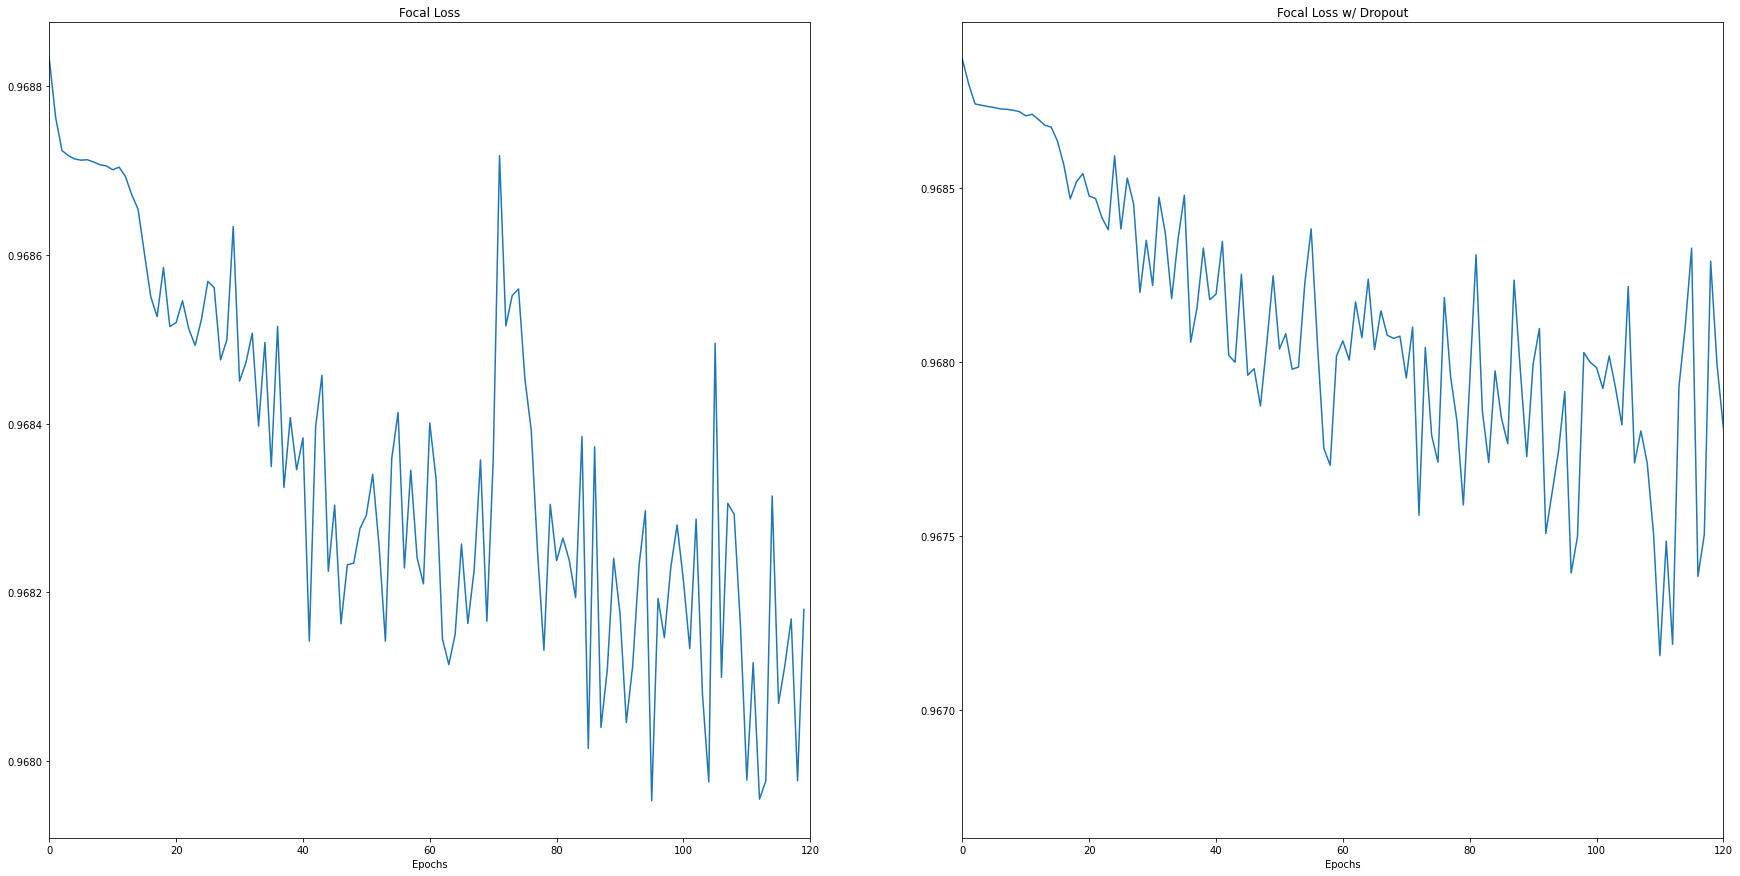

In [23]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0].set_xlabel('Epochs')
axs[0].set_xlim([0,120])
axs[1].set_xlabel('Epochs')
axs[1].set_xlim([0,120])
axs[0].plot(train_loss)
axs[0].title.set_text('Focal Loss')
axs[1].plot(train_loss_dropout)
axs[1].title.set_text('Focal Loss w/ Dropout')

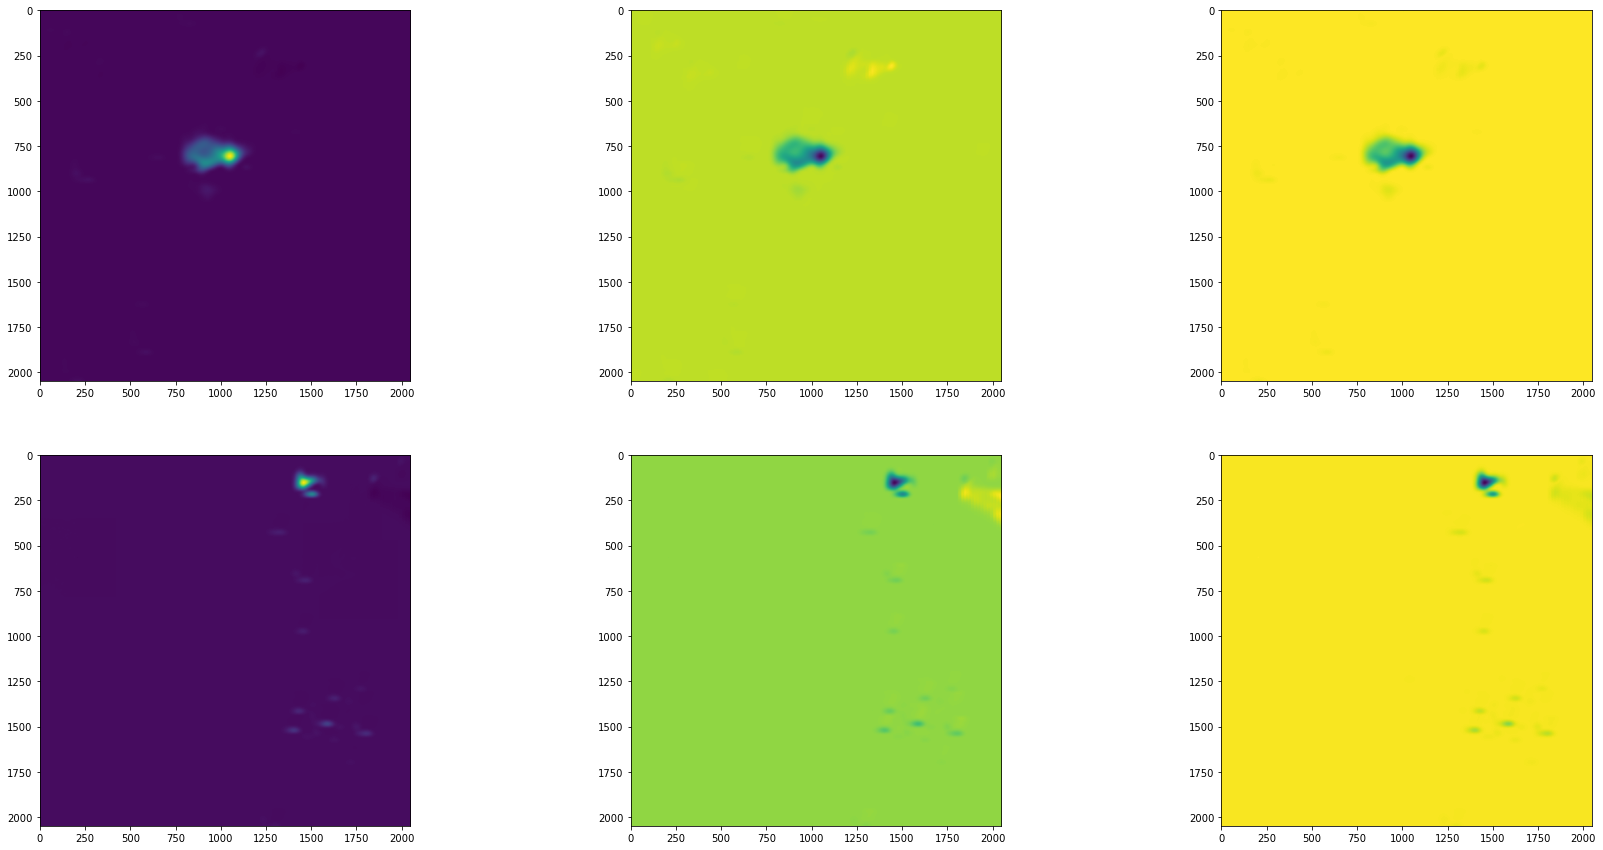

In [90]:
img_01 = torch.load('180_iou_loss_3_blob_dropout._0.pt').view(3,2048,2048).cpu()
img_01 = img_01.detach().numpy()

img_2 = torch.load('180_iou_loss_3_blob_dropout._1.pt').view(3,2048,2048).cpu()
img_2 = img_2.detach().numpy()

fig, axs = plt.subplots(2,3)
fig.set_figheight(15)
fig.set_figwidth(30)
axs[0][0].imshow(img_01[0])
axs[0][1].imshow(img_01[1])
axs[0][2].imshow(img_01[2])
axs[1][0].imshow(img_2[0])
axs[1][1].imshow(img_2[1])
axs[1][2].imshow(img_2[2])
plt.show()